Credit Card Fraud Detection with Logistic Regression

In [1]:
# Import Necessary Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    precision_recall_curve, classification_report, confusion_matrix, roc_curve
)
from imblearn.under_sampling import RandomUnderSampler
import joblib

Load and Explore the Data

In [2]:
# Load and Explore the Data

lg_credit_fraud = pd.read_csv("C:\\Users\\USER\\Downloads\\creditcard.csv")

In [3]:
# Display first few rows

lg_credit_fraud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Check dataset structure

print(lg_credit_fraud.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Check for missing values

print(lg_credit_fraud.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [6]:
# Check class distribution
lg_credit_fraud["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
fraud_cases = lg_credit_fraud[lg_credit_fraud["Class"] == 1]
normal_cases = lg_credit_fraud[lg_credit_fraud["Class"] == 0]

In [8]:
fraud_cases.shape, normal_cases.shape

((492, 31), (284315, 31))

 Feature Distribution

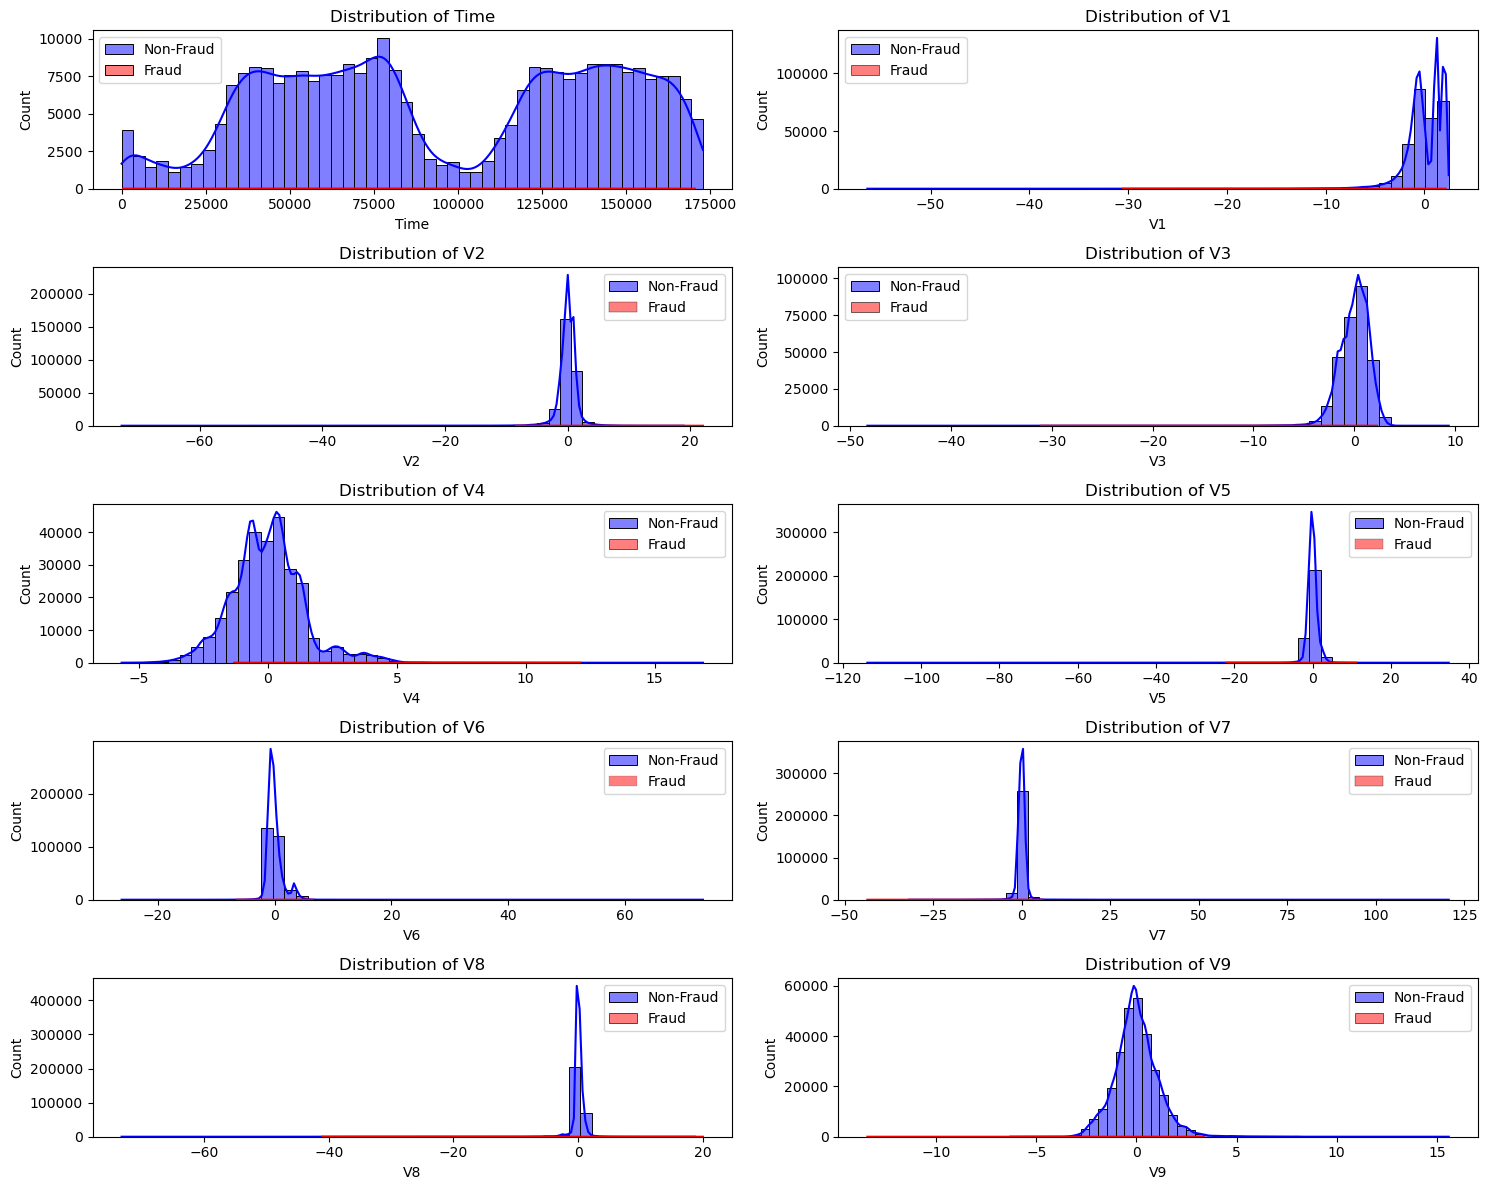

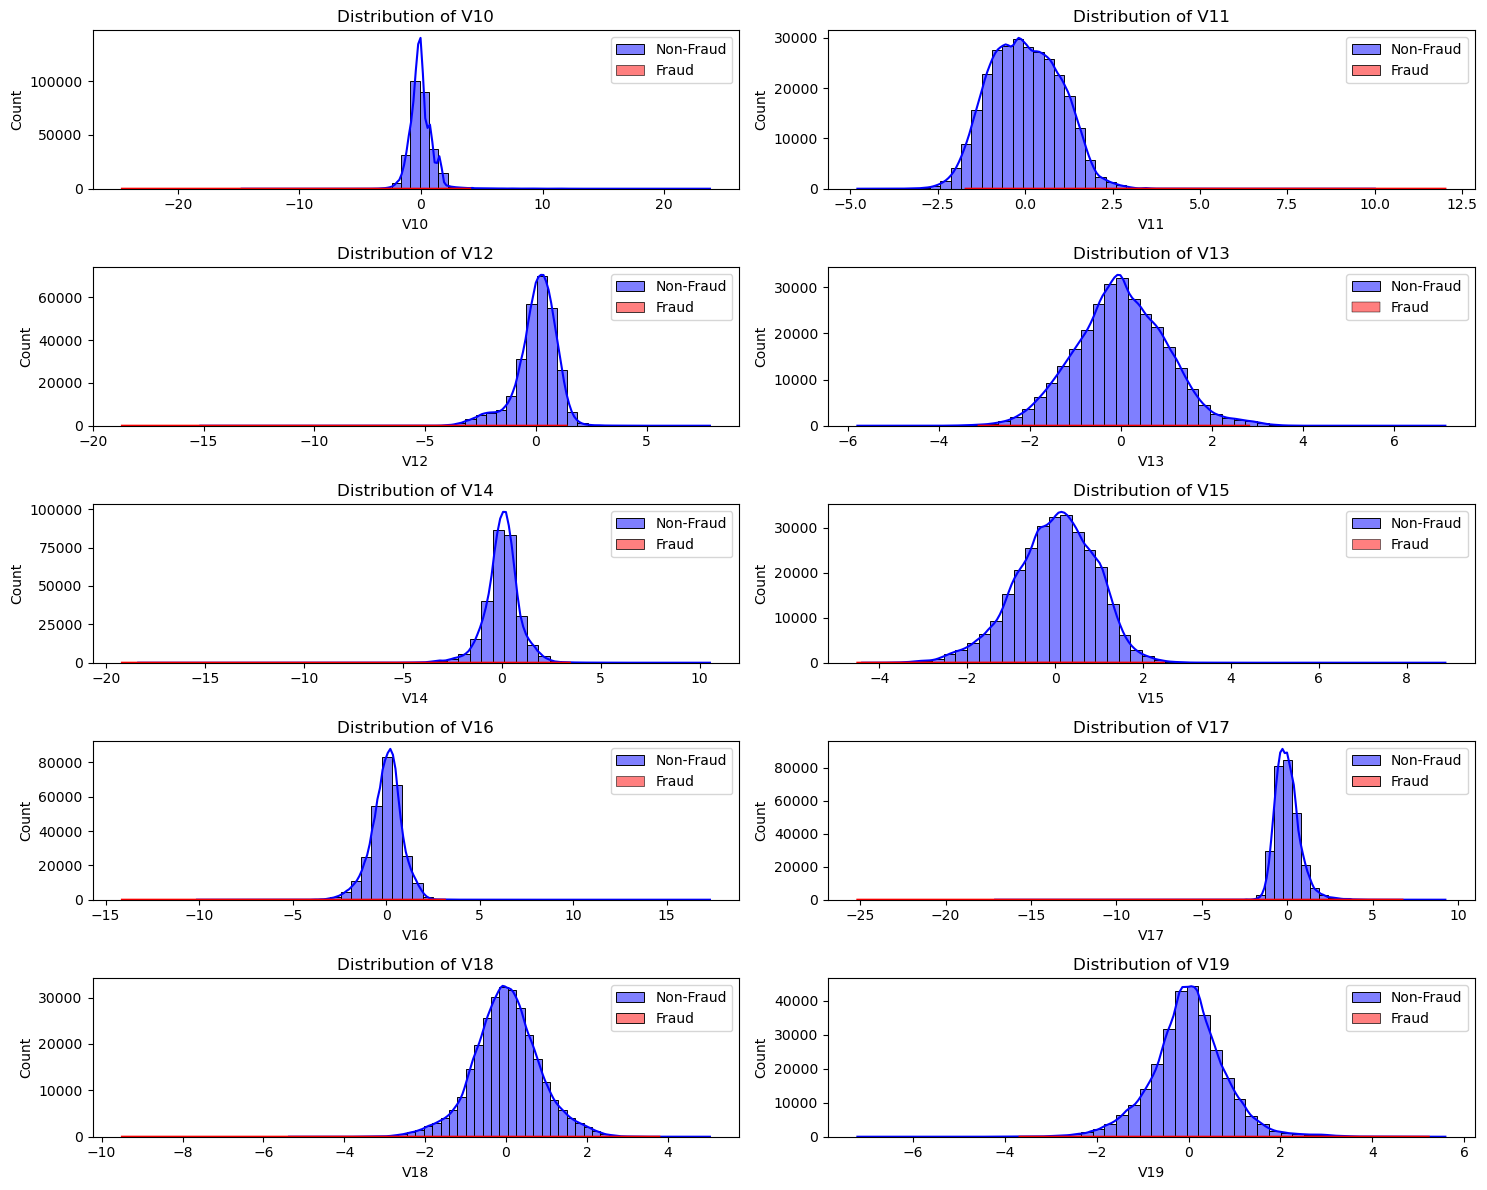

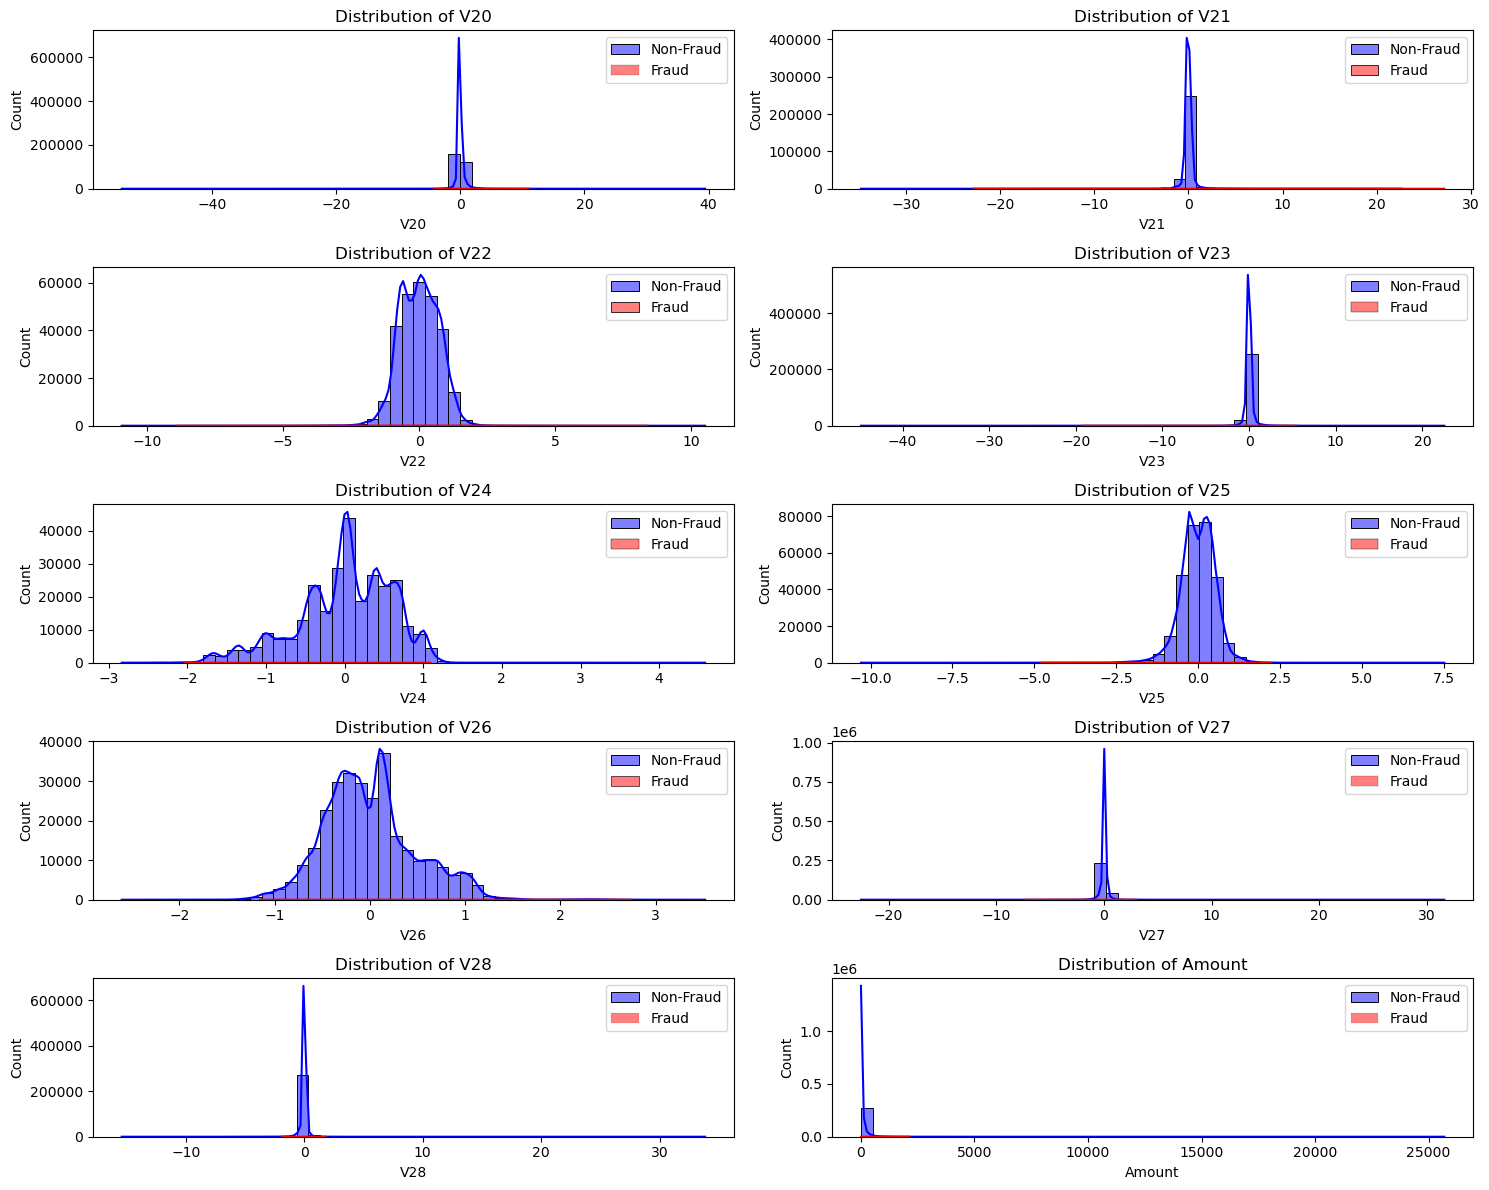

In [9]:
features = [col for col in lg_credit_fraud.columns if col != 'Class']

# Define number of features per batch
batch_size = 10  

for start in range(0, len(features), batch_size):
    plt.figure(figsize=(15, 12))
    
    for i, feature in enumerate(features[start:start + batch_size], 1):
        plt.subplot(5, 2, i)  # Adjust grid layout (5 rows, 2 columns)
        sns.histplot(lg_credit_fraud[lg_credit_fraud['Class'] == 0][feature], color='blue', label='Non-Fraud', bins=50, kde=True)
        sns.histplot(lg_credit_fraud[lg_credit_fraud['Class'] == 1][feature], color='red', label='Fraud', bins=50, kde=True)
        plt.legend()
        plt.title(f"Distribution of {feature}")
    
    plt.tight_layout()
    plt.show()


In [10]:
lg_credit_fraud.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.000644,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


Handle Class Imbalance (Undersampling)

In [11]:
normal_cases_sample = normal_cases.sample(n=492)

normal_cases_sample.shape, fraud_cases.shape

((492, 31), (492, 31))

In [12]:
new_lg_credit_fraud = pd.concat([normal_cases_sample, fraud_cases], axis= 0)

new_lg_credit_fraud

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
159949,113050.0,0.114697,0.796303,-0.149553,-0.823011,0.878763,-0.553152,0.939259,-0.108502,0.111137,...,-0.335776,-0.807853,-0.055940,-1.025281,-0.369557,0.204653,0.242724,0.085713,0.89,0
250190,154775.0,0.026150,-0.300790,0.455328,-1.668647,0.066089,0.581247,-0.149558,0.188651,-0.842865,...,-0.569258,-1.182642,0.391944,-0.212058,-0.827405,0.156693,-0.077551,-0.027061,38.00,0
274327,165959.0,1.934300,-0.419553,-0.341379,0.306888,-0.460018,0.123156,-0.701870,0.132172,1.079546,...,0.252760,0.941287,0.135180,0.809128,-0.088493,-0.271910,0.037393,-0.036866,12.99,0
98864,66849.0,-0.314594,-0.254709,-0.372817,-2.683401,2.297784,3.001204,-0.288818,0.731552,-1.007975,...,0.011756,-0.112503,-0.027963,0.889486,0.146215,-0.457787,0.090919,-0.123970,49.90,0
181138,124843.0,-0.151903,-1.218734,1.200583,-2.690720,-1.140659,2.633990,-2.795182,-1.850952,-1.142721,...,-1.375687,0.645453,-0.059049,-1.649621,0.338022,-0.103113,0.199621,0.249890,66.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,...,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,...,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,...,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,...,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,245.00,1


In [13]:
new_lg_credit_fraud['Class'].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

In [14]:
new_lg_credit_fraud.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Class,,,,,,,,,,,,,,,,,,,,,
0,97441.965447,0.036685,0.020677,-0.016156,-0.048986,0.080668,0.063835,0.027522,-0.007135,0.003126,...,0.015665,0.043665,-0.057625,0.009957,0.054655,-0.019791,-0.035424,-0.015343,-0.005916,89.834024
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321


Feature seperating

In [15]:
# Define features & target

X = new_lg_credit_fraud.drop(columns = 'Class', axis = 1)
Y = new_lg_credit_fraud['Class']

In [42]:
# Sample 5 records from Class 0
class_0_sample = X_test[Y_test == 0].sample(50, random_state=42)

# Sample 5 records from Class 1
class_1_sample = X_test[Y_test == 1].sample(50, random_state=42)

# Combine the samples
X_manual_samplessdd = pd.concat([class_0_sample, class_1_sample])

# Get the corresponding labels
y_manual_samplessdd = Y_test.loc[X_manual_samplessdd.index]

# Save the original (unscaled) test samples for manual checking
X_manual_samplessdd.to_csv("manual_test_sample_rawdssdd.csv", index=False)
y_manual_samplessdd.to_csv("manual_test_sample_labelsdssdd.csv", index=False)

# Display the sampled data
print("Sampled Features:")
print(X_manual_samplessdd)
print("\nSampled Labels:")
print(y_manual_samplessdd)

Sampled Features:
            Time         V1         V2         V3         V4         V5  \
71895  -0.720451   1.273713  -0.487969   0.625643  -0.114437  -0.748633   
150454  0.094227  -2.121635   1.537419   0.079932  -0.652896   1.402391   
73232  -0.708786   1.051730   0.177643   1.553061   2.587707  -0.870603   
105707 -0.402735  -0.776716   0.824993   1.514088   0.026211   0.128083   
275078  1.622453  -7.940384   7.061918  -6.450898  -1.139953  -3.792820   
...          ...        ...        ...        ...        ...        ...   
184379  0.781827  -1.141559   1.927650  -3.905356  -0.073943  -0.044858   
151519  0.141180 -17.518909  12.572118 -19.038538  11.190895 -13.554721   
198868  0.917303   0.432554   1.861373  -4.310353   2.448080   4.574094   
79525  -0.645582  -2.630598   5.125759  -6.092255   5.527393   1.605145   
212644  1.048276  -2.356348   1.746360  -6.374624   1.772205  -3.439294   

              V6         V7        V8        V9  ...       V20       V21  \
71895

Split Features & Target

We separate the features from the target variable and split the data into training and testing sets.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

In [17]:
print(X.shape, X_train.shape, X_test.shape)

(984, 30) (787, 30) (197, 30)


In [18]:
print(type(X_train))  # Check if it's a NumPy array or a DataFrame
print(type(X_test))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


Train Logistic Regression Model

In [19]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only 'Amount' and 'Time' in the training set
X_train[['Amount', 'Time']] = scaler.fit_transform(X_train[['Amount', 'Time']])

# Transform 'Amount' and 'Time' in the test set (using the same scaler)
X_test[['Amount', 'Time']] = scaler.transform(X_test[['Amount', 'Time']])

In [20]:

model = LogisticRegression()
model.fit(X_train, Y_train)



# model = LogisticRegression(max_iter=500)
# model.fit(X_train_scaled, Y_train)

LogisticRegression()

Evaluate the Model

In [21]:
# Predictions
y_pred = model.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_pred)

# Print Results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


Accuracy: 0.9645
Precision: 0.9789
Recall: 0.9490
F1-Score: 0.9637
ROC-AUC Score: 0.9644


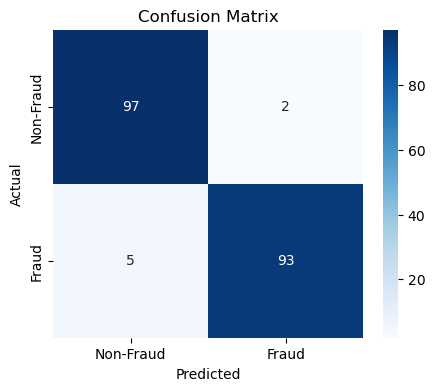

              precision    recall  f1-score   support

           0       0.95      0.98      0.97        99
           1       0.98      0.95      0.96        98

    accuracy                           0.96       197
   macro avg       0.96      0.96      0.96       197
weighted avg       0.96      0.96      0.96       197



In [22]:
# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(Y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(Y_test, y_pred))

adjust the threshold and re-evaluate

In [ ]:
# Get fraud probabilities
y_probs = model.predict_proba(X_test)[:, 1]  

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(Y_test, y_probs)

# Compute F1 scores, handling NaN cases
f1_scores = np.nan_to_num(2 * (precisions * recalls) / (precisions + recalls))

# Select the best threshold
best_threshold = thresholds[np.argmax(f1_scores[:-1])]
print(f"\n✅ Best Threshold: {best_threshold:.3f}")

# Function to adjust threshold and re-evaluate
def adjust_threshold(threshold=best_threshold):
    y_pred_new = (y_probs >= threshold).astype(int)
    
    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(Y_test, y_pred_new), annot=True, fmt="d", cmap="Blues", 
                xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Threshold = {threshold})")
    plt.show()
    
    # Compute evaluation metrics
    accuracy = accuracy_score(Y_test, y_pred_new)
    precision = precision_score(Y_test, y_pred_new)
    recall = recall_score(Y_test, y_pred_new)
    f1 = f1_score(Y_test, y_pred_new)
    roc_auc = roc_auc_score(Y_test, y_probs)
    
    # Print metrics
    print(f"Evaluation Metrics (Threshold = {threshold}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}\n")
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(Y_test, y_pred_new))

# Function to plot Precision-Recall Curve
def plot_precision_recall():
    plt.figure(figsize=(8, 6))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "r-", label="Recall")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Precision-Recall Curve")
    plt.show()



✅ Best Threshold: 0.892


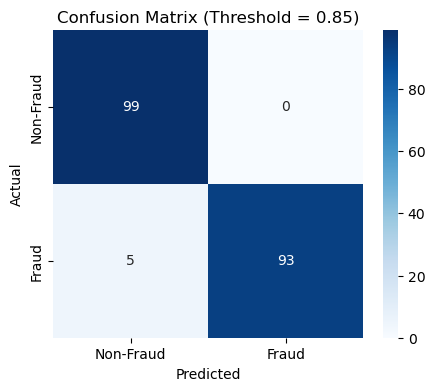

Evaluation Metrics (Threshold = 0.85):
Accuracy: 0.9746
Precision: 1.0000
Recall: 0.9490
F1-Score: 0.9738
ROC-AUC Score: 0.9856

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        99
           1       1.00      0.95      0.97        98

    accuracy                           0.97       197
   macro avg       0.98      0.97      0.97       197
weighted avg       0.98      0.97      0.97       197



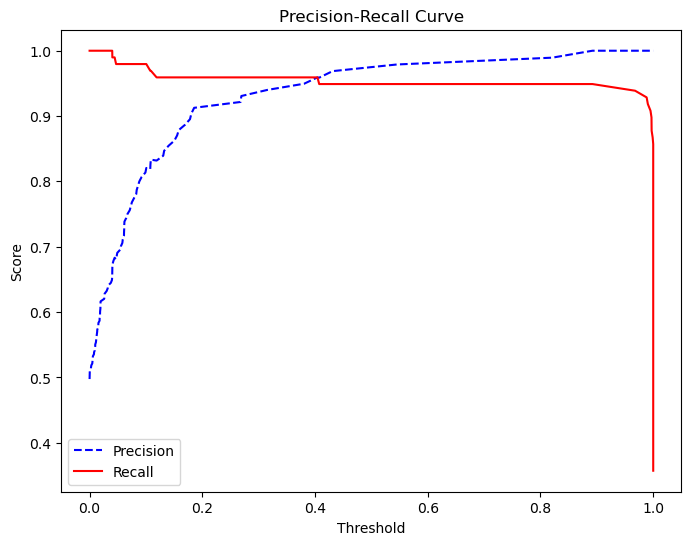

In [39]:
# Example Usage
adjust_threshold(0.85)  # Uses best threshold by default
plot_precision_recall()

save models

In [40]:
import joblib
import numpy as np
import pandas as pd

# Save the trained model
joblib.dump(model, "fraud_detection_model_lg.pkl")

# Save the best threshold
np.save("best_threshold_lg.npy", best_threshold)

# Save the scaler (used for 'Amount' and 'Time')
joblib.dump(scaler, "scaler_lg.pkl")

# Save the predicted probabilities
np.save("predicted_probs.npy", y_probs)

print("✅ All components saved successfully!")


✅ All components saved successfully!


In [46]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

best_f1 = 0
best_scale_pos_weight = None
best_model = None

# Try different scale_pos_weight values
for weight in [1, 5, 10, 25, 50, 75, 100]:
    print(f"\n🔹 Testing scale_pos_weight = {weight} 🔹")
    
    # Train model
    model = XGBClassifier(scale_pos_weight=weight, random_state=42)
    model.fit(X_train, Y_train)
    
    # Get probabilities and apply threshold
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= best_threshold).astype(int)
    
    # Evaluate
    report = classification_report(Y_test, y_pred, output_dict=True)
    f1 = report['1']['f1-score']  # F1-score for fraud class
    
    print(f"F1-Score: {f1:.4f}")
    
    # Keep track of the best model
    if f1 > best_f1:
        best_f1 = f1
        best_scale_pos_weight = weight
        best_model = model

# Print the best result
print(f"\n✅ Best scale_pos_weight: {best_scale_pos_weight} with F1-score: {best_f1:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, "best_cost_sensitive_xgb.pkl")
print("✅ Best model saved successfully!")



🔹 Testing scale_pos_weight = 1 🔹
F1-Score: 0.9583

🔹 Testing scale_pos_weight = 5 🔹
F1-Score: 0.9583

🔹 Testing scale_pos_weight = 10 🔹
F1-Score: 0.9583

🔹 Testing scale_pos_weight = 25 🔹
F1-Score: 0.9691

🔹 Testing scale_pos_weight = 50 🔹
F1-Score: 0.9538

🔹 Testing scale_pos_weight = 75 🔹
F1-Score: 0.9641

🔹 Testing scale_pos_weight = 100 🔹
F1-Score: 0.9592

✅ Best scale_pos_weight: 25 with F1-score: 0.9691
✅ Best model saved successfully!


In [47]:
from xgboost import XGBClassifier

# Adjust scale_pos_weight to focus on fraud detection
cost_sensitive_model = XGBClassifier(scale_pos_weight=25, random_state=42)  
cost_sensitive_model.fit(X_train, Y_train)

# Evaluate the new model
y_probs_cs = cost_sensitive_model.predict_proba(X_test)[:, 1]
y_pred_cs = (y_probs_cs >= best_threshold).astype(int)

print(classification_report(Y_test, y_pred_cs))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        99
           1       0.98      0.96      0.97        98

    accuracy                           0.97       197
   macro avg       0.97      0.97      0.97       197
weighted avg       0.97      0.97      0.97       197



In [49]:
# Save the trained model

joblib.dump(cost_sensitive_model, "cost_sensitive_xgb_model.pkl")

['cost_sensitive_xgb_model.pkl']

In [45]:
best_threshold

0.8922086764891026